In [1]:
from importlib import reload
import dataset as d; reload(d)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load data

In [2]:
df = d.load_dataset()

In [3]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Create X and Y

In [4]:
PREDICTED_COLUMNS = ['radius_mean', 'diagnosis']
FEATURES = ['mean']

In [5]:
x, y = d.create_xy(df, FEATURES, PREDICTED_COLUMNS)

In [6]:
x = d.preprocess_data(x)

## Split Train, Val & Test

In [7]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = d.split_train_val_test(x, y, train_perc=0.8)

In [8]:
print('# Examples for training:', len(x_train))
print('# Examples for validation:', len(x_val))
print('# Examples for test:',  len(x_test))

# Examples for training: 285
# Examples for validation: 142
# Examples for test: 142


## Evaluate Features

### Covariance Matrix

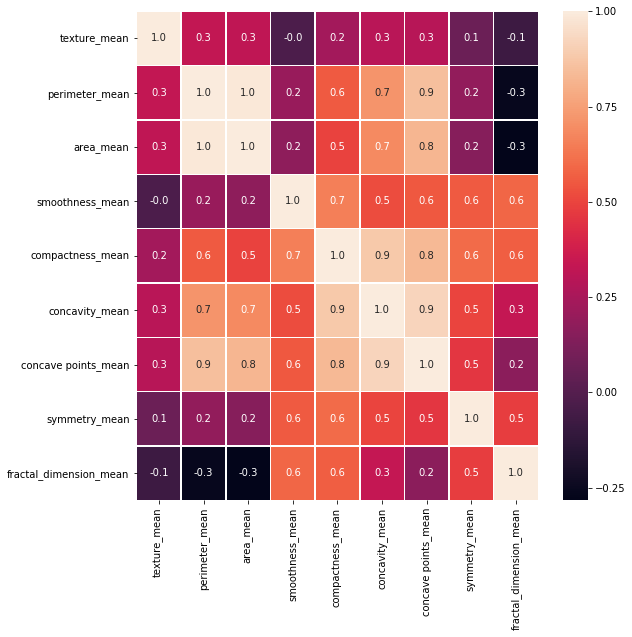

In [9]:
f, ax = plt.subplots(figsize=(x.shape[1], x.shape[1]))
sns.heatmap(x.corr(), annot=True, linewidths=.5, fmt= '.1f', ax=ax)

### PCA

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
basis = pca.fit(x_train)

In [11]:
x_train = basis.transform(x_train)
x_val = basis.transform(x_val)
x_test = basis.transform(x_test)

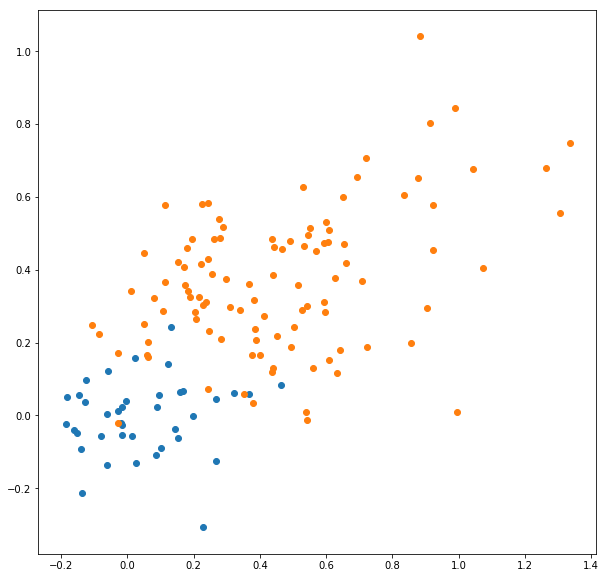

In [12]:
plt.figure(figsize=(10, 10))
plt.scatter(x_val[y_val[:, 1] == 'B', 0], x_val[y_val[:, 1] == 'B', 1])
plt.scatter(x_val[y_val[:, 1] == 'M', 0], x_val[y_val[:, 1] == 'M', 1])

## Ensemble of models

### Create an ensemble of models

In [13]:
import keras
from keras.layers import *
from keras.models import Model, Sequential
from keras.regularizers import l1_l2
from collections import defaultdict

c:\users\bearch\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [14]:
N_FEATURES = x_train.shape[1]

In [15]:
def create_base_model(input_size, n_hidden):
    i = Input((input_size, ))
    h = Dense(n_hidden, kernel_initializer='normal', use_bias=True, kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(i)
#     h = Dropout(0.6)(h)
    h = LeakyReLU()(h)
    o = Dense(1)(h)
    return Model(i, o)

In [16]:
models = []
N_MODELS = 5
n_hidden_neurons = 64
for _ in range(N_MODELS):
    models.append(create_base_model(N_FEATURES, n_hidden_neurons))

In [17]:
models[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________


### Train ensemble

In [18]:
def train(model, train_data, val_data, lr, batch_size, epochs=50, history=None):
    current_epoch = 0 if history is None else len(history.history['loss'])
    model.compile(
        loss='mean_squared_error',
        optimizer=keras.optimizers.Adam(lr=lr),
        metrics=['mse']
    )
    
    new_history = model.fit(
        train_data[0], train_data[1], epochs=current_epoch+epochs,
        batch_size=batch_size,
        validation_data=val_data,
        initial_epoch=current_epoch,
        verbose=1
    )
    
    if history is not None:
        for key in new_history.history:
            history.history[key].extend(new_history.history[key])
    else:
        history = new_history
    
    return history

In [19]:
histories = defaultdict(lambda: None)

In [20]:
for lr in [0.5, 0.1, 0.05, 0.01]:
    for i in range(N_MODELS):
        histories[i] = train(models[i], [x_train, y_train[:, 0]], (x_val, y_val[:, 0]), lr, 500, history=histories[i])

Train on 285 samples, validate on 142 samples
Epoch 1/50
285/285 [==============================] - 3s 9ms/step - loss: 150.6786 - mean_squared_error: 150.5614 - val_loss: 119.6611 - val_mean_squared_error: 118.3877
Epoch 2/50
285/285 [==============================] - 0s 17us/step - loss: 51.7795 - mean_squared_error: 50.5062 - val_loss: 60.5063 - val_mean_squared_error: 58.4714
Epoch 3/50
285/285 [==============================] - 0s 21us/step - loss: 67.4038 - mean_squared_error: 65.3689 - val_loss: 23.4124 - val_mean_squared_error: 21.1587
Epoch 4/50
285/285 [==============================] - 0s 28us/step - loss: 6.6977 - mean_squared_error: 4.4440 - val_loss: 18.8589 - val_mean_squared_error: 16.6882
Epoch 5/50
285/285 [==============================] - 0s 21us/step - loss: 23.4711 - mean_squared_error: 21.3004 - val_loss: 36.4455 - val_mean_squared_error: 34.4354
Epoch 6/50
285/285 [==============================] - 0s 21us/step - loss: 34.1233 - mean_squared_error: 32.1132 - val

Train on 285 samples, validate on 142 samples
Epoch 1/50
285/285 [==============================] - 0s 913us/step - loss: 150.5301 - mean_squared_error: 150.4267 - val_loss: 73.5381 - val_mean_squared_error: 72.2354
Epoch 2/50
285/285 [==============================] - 0s 18us/step - loss: 36.9347 - mean_squared_error: 35.6320 - val_loss: 176.7687 - val_mean_squared_error: 174.4851
Epoch 3/50
285/285 [==============================] - 0s 21us/step - loss: 132.8213 - mean_squared_error: 130.5376 - val_loss: 12.1722 - val_mean_squared_error: 9.9497
Epoch 4/50
285/285 [==============================] - 0s 21us/step - loss: 4.4994 - mean_squared_error: 2.2769 - val_loss: 48.0734 - val_mean_squared_error: 46.1139
Epoch 5/50
285/285 [==============================] - 0s 28us/step - loss: 40.1048 - mean_squared_error: 38.1452 - val_loss: 96.6210 - val_mean_squared_error: 94.8923
Epoch 6/50
285/285 [==============================] - 0s 17us/step - loss: 67.9629 - mean_squared_error: 66.2342 - 

Train on 285 samples, validate on 142 samples
Epoch 1/50
285/285 [==============================] - 0s 1ms/step - loss: 150.6687 - mean_squared_error: 150.5725 - val_loss: 129.1712 - val_mean_squared_error: 127.8928
Epoch 2/50
285/285 [==============================] - 0s 18us/step - loss: 50.4436 - mean_squared_error: 49.1652 - val_loss: 86.1325 - val_mean_squared_error: 84.0752
Epoch 3/50
285/285 [==============================] - 0s 28us/step - loss: 72.5442 - mean_squared_error: 70.4868 - val_loss: 22.9258 - val_mean_squared_error: 20.5850
Epoch 4/50
285/285 [==============================] - 0s 21us/step - loss: 6.5640 - mean_squared_error: 4.2233 - val_loss: 27.6624 - val_mean_squared_error: 25.3672
Epoch 5/50
285/285 [==============================] - 0s 17us/step - loss: 25.1627 - mean_squared_error: 22.8675 - val_loss: 51.7868 - val_mean_squared_error: 49.6274
Epoch 6/50
285/285 [==============================] - 0s 28us/step - loss: 36.9928 - mean_squared_error: 34.8334 - val

Train on 285 samples, validate on 142 samples
Epoch 1/50
285/285 [==============================] - 0s 1ms/step - loss: 150.6073 - mean_squared_error: 150.5008 - val_loss: 117.6023 - val_mean_squared_error: 116.3117
Epoch 2/50
285/285 [==============================] - 0s 17us/step - loss: 49.4524 - mean_squared_error: 48.1617 - val_loss: 101.1916 - val_mean_squared_error: 99.0091
Epoch 3/50
285/285 [==============================] - 0s 25us/step - loss: 74.8655 - mean_squared_error: 72.6830 - val_loss: 12.1470 - val_mean_squared_error: 9.8485
Epoch 4/50
285/285 [==============================] - 0s 21us/step - loss: 6.3271 - mean_squared_error: 4.0285 - val_loss: 31.5483 - val_mean_squared_error: 29.4373
Epoch 5/50
285/285 [==============================] - 0s 17us/step - loss: 25.1040 - mean_squared_error: 22.9930 - val_loss: 52.4640 - val_mean_squared_error: 50.5559
Epoch 6/50
285/285 [==============================] - 0s 31us/step - loss: 37.9335 - mean_squared_error: 36.0254 - val

Train on 285 samples, validate on 142 samples
Epoch 1/50
285/285 [==============================] - 0s 1ms/step - loss: 150.5863 - mean_squared_error: 150.4877 - val_loss: 89.9360 - val_mean_squared_error: 88.6556
Epoch 2/50
285/285 [==============================] - 0s 18us/step - loss: 39.6316 - mean_squared_error: 38.3513 - val_loss: 168.1872 - val_mean_squared_error: 166.0063
Epoch 3/50
285/285 [==============================] - 0s 24us/step - loss: 116.6014 - mean_squared_error: 114.4204 - val_loss: 17.6724 - val_mean_squared_error: 15.5248
Epoch 4/50
285/285 [==============================] - 0s 17us/step - loss: 4.8191 - mean_squared_error: 2.6715 - val_loss: 46.3673 - val_mean_squared_error: 44.4711
Epoch 5/50
285/285 [==============================] - 0s 24us/step - loss: 36.3051 - mean_squared_error: 34.4089 - val_loss: 96.7828 - val_mean_squared_error: 95.0280
Epoch 6/50
285/285 [==============================] - 0s 28us/step - loss: 60.0756 - mean_squared_error: 58.3208 - v

Train on 285 samples, validate on 142 samples
Epoch 51/100
285/285 [==============================] - 0s 1ms/step - loss: 0.8159 - mean_squared_error: 0.1935 - val_loss: 12.3316 - val_mean_squared_error: 11.7662
Epoch 52/100
285/285 [==============================] - 0s 17us/step - loss: 9.3855 - mean_squared_error: 8.8200 - val_loss: 1.0415 - val_mean_squared_error: 0.4128
Epoch 53/100
285/285 [==============================] - 0s 21us/step - loss: 1.0232 - mean_squared_error: 0.3945 - val_loss: 7.4657 - val_mean_squared_error: 6.8268
Epoch 54/100
285/285 [==============================] - 0s 28us/step - loss: 5.4551 - mean_squared_error: 4.8161 - val_loss: 7.6926 - val_mean_squared_error: 7.0814
Epoch 55/100
285/285 [==============================] - 0s 21us/step - loss: 5.6336 - mean_squared_error: 5.0224 - val_loss: 1.6649 - val_mean_squared_error: 1.1052
Epoch 56/100
285/285 [==============================] - 0s 17us/step - loss: 1.7707 - mean_squared_error: 1.2111 - val_loss: 1.9

Train on 285 samples, validate on 142 samples
Epoch 51/100
285/285 [==============================] - 0s 1ms/step - loss: 1.1257 - mean_squared_error: 0.3885 - val_loss: 9.2864 - val_mean_squared_error: 8.6893
Epoch 52/100
285/285 [==============================] - 0s 18us/step - loss: 5.0704 - mean_squared_error: 4.4733 - val_loss: 1.9386 - val_mean_squared_error: 1.2862
Epoch 53/100
285/285 [==============================] - 0s 21us/step - loss: 1.1383 - mean_squared_error: 0.4859 - val_loss: 2.7550 - val_mean_squared_error: 2.0248
Epoch 54/100
285/285 [==============================] - 0s 21us/step - loss: 2.8031 - mean_squared_error: 2.0728 - val_loss: 3.3665 - val_mean_squared_error: 2.6371
Epoch 55/100
285/285 [==============================] - 0s 21us/step - loss: 2.8205 - mean_squared_error: 2.0911 - val_loss: 1.1059 - val_mean_squared_error: 0.4236
Epoch 56/100
285/285 [==============================] - 0s 35us/step - loss: 1.0579 - mean_squared_error: 0.3757 - val_loss: 1.979

Train on 285 samples, validate on 142 samples
Epoch 51/100
285/285 [==============================] - 0s 1ms/step - loss: 1.0342 - mean_squared_error: 0.4156 - val_loss: 13.5457 - val_mean_squared_error: 12.8604
Epoch 52/100
285/285 [==============================] - 0s 17us/step - loss: 8.5685 - mean_squared_error: 7.8832 - val_loss: 0.8181 - val_mean_squared_error: 0.2089
Epoch 53/100
285/285 [==============================] - 0s 25us/step - loss: 0.9501 - mean_squared_error: 0.3408 - val_loss: 7.6518 - val_mean_squared_error: 7.0953
Epoch 54/100
285/285 [==============================] - 0s 28us/step - loss: 3.9845 - mean_squared_error: 3.4280 - val_loss: 8.8297 - val_mean_squared_error: 8.2709
Epoch 55/100
285/285 [==============================] - 0s 21us/step - loss: 5.5928 - mean_squared_error: 5.0340 - val_loss: 3.5949 - val_mean_squared_error: 2.9915
Epoch 56/100
285/285 [==============================] - 0s 21us/step - loss: 2.9448 - mean_squared_error: 2.3414 - val_loss: 0.9

Train on 285 samples, validate on 142 samples
Epoch 51/100
285/285 [==============================] - 1s 2ms/step - loss: 1.0080 - mean_squared_error: 0.3925 - val_loss: 12.7354 - val_mean_squared_error: 12.0724
Epoch 52/100
285/285 [==============================] - 0s 28us/step - loss: 8.0996 - mean_squared_error: 7.4366 - val_loss: 0.8168 - val_mean_squared_error: 0.2209
Epoch 53/100
285/285 [==============================] - 0s 21us/step - loss: 0.9381 - mean_squared_error: 0.3422 - val_loss: 7.4436 - val_mean_squared_error: 6.8668
Epoch 54/100
285/285 [==============================] - 0s 38us/step - loss: 3.6847 - mean_squared_error: 3.1079 - val_loss: 8.7379 - val_mean_squared_error: 8.1489
Epoch 55/100
285/285 [==============================] - 0s 24us/step - loss: 5.2933 - mean_squared_error: 4.7043 - val_loss: 3.6028 - val_mean_squared_error: 2.9810
Epoch 56/100
285/285 [==============================] - 0s 28us/step - loss: 2.9689 - mean_squared_error: 2.3471 - val_loss: 0.9

Train on 285 samples, validate on 142 samples
Epoch 51/100
285/285 [==============================] - 0s 2ms/step - loss: 1.0584 - mean_squared_error: 0.3572 - val_loss: 15.9713 - val_mean_squared_error: 15.4016
Epoch 52/100
285/285 [==============================] - 0s 17us/step - loss: 7.6718 - mean_squared_error: 7.1021 - val_loss: 1.9386 - val_mean_squared_error: 1.3076
Epoch 53/100
285/285 [==============================] - 0s 18us/step - loss: 1.0743 - mean_squared_error: 0.4433 - val_loss: 5.7471 - val_mean_squared_error: 5.0516
Epoch 54/100
285/285 [==============================] - 0s 24us/step - loss: 4.2396 - mean_squared_error: 3.5441 - val_loss: 6.5307 - val_mean_squared_error: 5.8313
Epoch 55/100
285/285 [==============================] - 0s 21us/step - loss: 4.3035 - mean_squared_error: 3.6041 - val_loss: 1.5507 - val_mean_squared_error: 0.8949
Epoch 56/100
285/285 [==============================] - 0s 24us/step - loss: 1.4018 - mean_squared_error: 0.7461 - val_loss: 1.9

Train on 285 samples, validate on 142 samples
Epoch 101/150
285/285 [==============================] - 1s 2ms/step - loss: 0.6746 - mean_squared_error: 0.1807 - val_loss: 1.2001 - val_mean_squared_error: 0.7264
Epoch 102/150
285/285 [==============================] - 0s 17us/step - loss: 1.1511 - mean_squared_error: 0.6773 - val_loss: 1.0756 - val_mean_squared_error: 0.5853
Epoch 103/150
285/285 [==============================] - 0s 21us/step - loss: 0.9036 - mean_squared_error: 0.4133 - val_loss: 1.1505 - val_mean_squared_error: 0.6780
Epoch 104/150
285/285 [==============================] - 0s 28us/step - loss: 1.0390 - mean_squared_error: 0.5665 - val_loss: 0.6509 - val_mean_squared_error: 0.1950
Epoch 105/150
285/285 [==============================] - 0s 17us/step - loss: 0.6494 - mean_squared_error: 0.1936 - val_loss: 0.9405 - val_mean_squared_error: 0.4904
Epoch 106/150
285/285 [==============================] - 0s 24us/step - loss: 0.8395 - mean_squared_error: 0.3893 - val_loss:

285/285 [==============================] - 0s 25us/step - loss: 0.5463 - mean_squared_error: 0.1684 - val_loss: 0.6202 - val_mean_squared_error: 0.2424
Train on 285 samples, validate on 142 samples
Epoch 101/150
285/285 [==============================] - 0s 2ms/step - loss: 0.6549 - mean_squared_error: 0.1828 - val_loss: 1.8262 - val_mean_squared_error: 1.3738
Epoch 102/150
285/285 [==============================] - 0s 21us/step - loss: 2.1661 - mean_squared_error: 1.7137 - val_loss: 0.6588 - val_mean_squared_error: 0.1875
Epoch 103/150
285/285 [==============================] - 0s 25us/step - loss: 0.6954 - mean_squared_error: 0.2241 - val_loss: 1.2883 - val_mean_squared_error: 0.7978
Epoch 104/150
285/285 [==============================] - 0s 24us/step - loss: 1.2379 - mean_squared_error: 0.7474 - val_loss: 1.4525 - val_mean_squared_error: 0.9404
Epoch 105/150
285/285 [==============================] - 0s 21us/step - loss: 1.6450 - mean_squared_error: 1.1329 - val_loss: 1.0260 - val_

Epoch 150/150
285/285 [==============================] - 0s 28us/step - loss: 0.5736 - mean_squared_error: 0.1735 - val_loss: 0.6250 - val_mean_squared_error: 0.2315
Train on 285 samples, validate on 142 samples
Epoch 101/150
285/285 [==============================] - 1s 2ms/step - loss: 0.6788 - mean_squared_error: 0.1995 - val_loss: 4.0926 - val_mean_squared_error: 3.5608
Epoch 102/150
285/285 [==============================] - 0s 17us/step - loss: 2.5408 - mean_squared_error: 2.0090 - val_loss: 0.7356 - val_mean_squared_error: 0.2279
Epoch 103/150
285/285 [==============================] - 0s 24us/step - loss: 0.7132 - mean_squared_error: 0.2056 - val_loss: 2.1942 - val_mean_squared_error: 1.7117
Epoch 104/150
285/285 [==============================] - 0s 24us/step - loss: 1.5022 - mean_squared_error: 1.0197 - val_loss: 2.8770 - val_mean_squared_error: 2.3936
Epoch 105/150
285/285 [==============================] - 0s 21us/step - loss: 1.9558 - mean_squared_error: 1.4724 - val_loss:

Epoch 150/150
285/285 [==============================] - 0s 21us/step - loss: 0.6082 - mean_squared_error: 0.1848 - val_loss: 0.6665 - val_mean_squared_error: 0.2455
Train on 285 samples, validate on 142 samples
Epoch 101/150
285/285 [==============================] - 1s 2ms/step - loss: 0.6929 - mean_squared_error: 0.2070 - val_loss: 1.8154 - val_mean_squared_error: 1.2722
Epoch 102/150
285/285 [==============================] - 0s 17us/step - loss: 1.9969 - mean_squared_error: 1.4537 - val_loss: 0.7563 - val_mean_squared_error: 0.2371
Epoch 103/150
285/285 [==============================] - 0s 25us/step - loss: 0.7289 - mean_squared_error: 0.2096 - val_loss: 1.1482 - val_mean_squared_error: 0.6643
Epoch 104/150
285/285 [==============================] - 0s 28us/step - loss: 1.3242 - mean_squared_error: 0.8402 - val_loss: 1.1088 - val_mean_squared_error: 0.6402
Epoch 105/150
285/285 [==============================] - 0s 18us/step - loss: 1.4516 - mean_squared_error: 0.9830 - val_loss:

285/285 [==============================] - 0s 28us/step - loss: 0.5908 - mean_squared_error: 0.1785 - val_loss: 0.6524 - val_mean_squared_error: 0.2423
Epoch 150/150
285/285 [==============================] - 0s 24us/step - loss: 0.5925 - mean_squared_error: 0.1824 - val_loss: 0.6429 - val_mean_squared_error: 0.2351
Train on 285 samples, validate on 142 samples
Epoch 101/150
285/285 [==============================] - 1s 2ms/step - loss: 0.7256 - mean_squared_error: 0.2020 - val_loss: 3.1865 - val_mean_squared_error: 2.6886
Epoch 102/150
285/285 [==============================] - 0s 21us/step - loss: 1.9848 - mean_squared_error: 1.4869 - val_loss: 0.9257 - val_mean_squared_error: 0.4033
Epoch 103/150
285/285 [==============================] - 0s 35us/step - loss: 0.7579 - mean_squared_error: 0.2355 - val_loss: 1.4616 - val_mean_squared_error: 0.9200
Epoch 104/150
285/285 [==============================] - 0s 28us/step - loss: 1.3154 - mean_squared_error: 0.7738 - val_loss: 2.0468 - val_

Epoch 149/150
285/285 [==============================] - 0s 28us/step - loss: 0.6061 - mean_squared_error: 0.1747 - val_loss: 0.6846 - val_mean_squared_error: 0.2528
Epoch 150/150
285/285 [==============================] - 0s 18us/step - loss: 0.6079 - mean_squared_error: 0.1761 - val_loss: 0.6857 - val_mean_squared_error: 0.2576
Train on 285 samples, validate on 142 samples
Epoch 151/200
285/285 [==============================] - 1s 2ms/step - loss: 0.5426 - mean_squared_error: 0.1647 - val_loss: 0.6200 - val_mean_squared_error: 0.2482
Epoch 152/200
285/285 [==============================] - 0s 21us/step - loss: 0.5591 - mean_squared_error: 0.1873 - val_loss: 0.6511 - val_mean_squared_error: 0.2840
Epoch 153/200
285/285 [==============================] - 0s 32us/step - loss: 0.5408 - mean_squared_error: 0.1737 - val_loss: 0.6854 - val_mean_squared_error: 0.3177
Epoch 154/200
285/285 [==============================] - 0s 18us/step - loss: 0.5559 - mean_squared_error: 0.1882 - val_loss:

Epoch 199/200
285/285 [==============================] - 0s 21us/step - loss: 0.4849 - mean_squared_error: 0.1588 - val_loss: 0.6008 - val_mean_squared_error: 0.2756
Epoch 200/200
285/285 [==============================] - 0s 35us/step - loss: 0.4837 - mean_squared_error: 0.1585 - val_loss: 0.6015 - val_mean_squared_error: 0.2774
Train on 285 samples, validate on 142 samples
Epoch 151/200
285/285 [==============================] - 1s 2ms/step - loss: 0.5672 - mean_squared_error: 0.1737 - val_loss: 0.6157 - val_mean_squared_error: 0.2269
Epoch 152/200
285/285 [==============================] - 0s 21us/step - loss: 0.5879 - mean_squared_error: 0.1990 - val_loss: 0.6309 - val_mean_squared_error: 0.2415
Epoch 153/200
285/285 [==============================] - 0s 28us/step - loss: 0.5580 - mean_squared_error: 0.1687 - val_loss: 0.6917 - val_mean_squared_error: 0.3027
Epoch 154/200
285/285 [==============================] - 0s 21us/step - loss: 0.5724 - mean_squared_error: 0.1834 - val_loss:

Epoch 199/200
285/285 [==============================] - 0s 38us/step - loss: 0.4864 - mean_squared_error: 0.1596 - val_loss: 0.5879 - val_mean_squared_error: 0.2624
Epoch 200/200
285/285 [==============================] - 0s 21us/step - loss: 0.4848 - mean_squared_error: 0.1593 - val_loss: 0.5958 - val_mean_squared_error: 0.2716
Train on 285 samples, validate on 142 samples
Epoch 151/200
285/285 [==============================] - 1s 2ms/step - loss: 0.6000 - mean_squared_error: 0.1789 - val_loss: 0.6550 - val_mean_squared_error: 0.2373
Epoch 152/200
285/285 [==============================] - 0s 17us/step - loss: 0.6368 - mean_squared_error: 0.2190 - val_loss: 0.6286 - val_mean_squared_error: 0.2108
Epoch 153/200
285/285 [==============================] - 0s 28us/step - loss: 0.5937 - mean_squared_error: 0.1760 - val_loss: 0.6808 - val_mean_squared_error: 0.2644
Epoch 154/200
285/285 [==============================] - 0s 21us/step - loss: 0.6083 - mean_squared_error: 0.1919 - val_loss:

Epoch 199/200
285/285 [==============================] - 0s 28us/step - loss: 0.5253 - mean_squared_error: 0.1645 - val_loss: 0.6034 - val_mean_squared_error: 0.2439
Epoch 200/200
285/285 [==============================] - 0s 35us/step - loss: 0.5241 - mean_squared_error: 0.1646 - val_loss: 0.6010 - val_mean_squared_error: 0.2432
Train on 285 samples, validate on 142 samples
Epoch 151/200
285/285 [==============================] - 1s 2ms/step - loss: 0.5873 - mean_squared_error: 0.1795 - val_loss: 0.6355 - val_mean_squared_error: 0.2316
Epoch 152/200
285/285 [==============================] - 0s 21us/step - loss: 0.6150 - mean_squared_error: 0.2111 - val_loss: 0.6184 - val_mean_squared_error: 0.2112
Epoch 153/200
285/285 [==============================] - 0s 32us/step - loss: 0.5808 - mean_squared_error: 0.1735 - val_loss: 0.6801 - val_mean_squared_error: 0.2724
Epoch 154/200
285/285 [==============================] - 0s 21us/step - loss: 0.5910 - mean_squared_error: 0.1834 - val_loss:

Epoch 199/200
285/285 [==============================] - 0s 28us/step - loss: 0.5116 - mean_squared_error: 0.1632 - val_loss: 0.5938 - val_mean_squared_error: 0.2467
Epoch 200/200
285/285 [==============================] - 0s 31us/step - loss: 0.5101 - mean_squared_error: 0.1629 - val_loss: 0.5987 - val_mean_squared_error: 0.2532
Train on 285 samples, validate on 142 samples
Epoch 151/200
285/285 [==============================] - 1s 3ms/step - loss: 0.6062 - mean_squared_error: 0.1781 - val_loss: 0.6464 - val_mean_squared_error: 0.2293
Epoch 152/200
285/285 [==============================] - 0s 17us/step - loss: 0.6247 - mean_squared_error: 0.2076 - val_loss: 0.6222 - val_mean_squared_error: 0.2054
Epoch 153/200
285/285 [==============================] - 0s 28us/step - loss: 0.5994 - mean_squared_error: 0.1826 - val_loss: 0.6523 - val_mean_squared_error: 0.2334
Epoch 154/200
285/285 [==============================] - 0s 24us/step - loss: 0.6017 - mean_squared_error: 0.1828 - val_loss:

Epoch 199/200
285/285 [==============================] - 0s 28us/step - loss: 0.5162 - mean_squared_error: 0.1644 - val_loss: 0.6025 - val_mean_squared_error: 0.2514
Epoch 200/200
285/285 [==============================] - 0s 28us/step - loss: 0.5144 - mean_squared_error: 0.1632 - val_loss: 0.6044 - val_mean_squared_error: 0.2539


## Predict target feature using ensemble

In [21]:
y_train_preds = []
y_val_preds = []
y_test_preds = []

for model in models:
    y_train_preds.append(model.predict(x_train))
    y_val_preds.append(model.predict(x_val))
    y_test_preds.append(model.predict(x_test))

## Use ensemble variance to predict diagnosis 

In [22]:
y_train_preds_var = np.var(y_train_preds, axis=0)
y_val_preds_var = np.var(y_val_preds, axis=0)
y_test_preds_var = np.var(y_test_preds, axis=0)

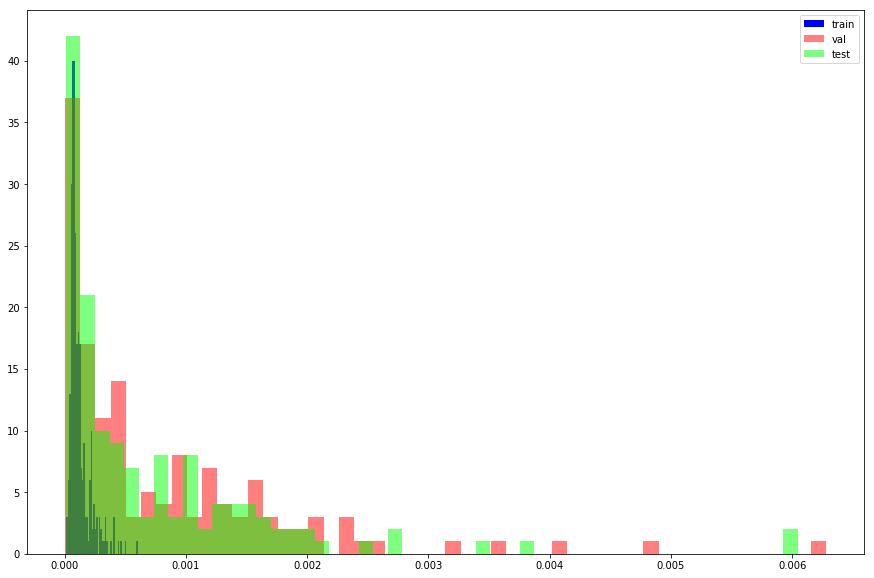

In [23]:
plt.figure(figsize=(15, 10))
plt.hist(y_train_preds_var, color='b',  bins=50, label='train')
plt.hist(y_val_preds_var, fc=(1, 0, 0, 0.5), bins=50, label='val')
plt.hist(y_test_preds_var, fc=(0, 1, 0, 0.5), bins=50, label='test')
plt.legend()
plt.show()

### Select variance threshold

In [24]:
# THIS FUNCTION IS NOT WEIGHTED BUT IT SHOULD BE IN NEXT IMPLEMENTATION
def weighted_accuracy(y_preds_var, y, threshold):
    accs = []
    
    for i, pred in enumerate(y_preds_var):
        if y[i, 1] == 'B':
            accs.append((pred < threshold))
        elif y[i, 1] == 'M':
            accs.append((pred > threshold))
    
    return np.average(accs)

In [30]:
thresholds = np.linspace(0, 3, 100) *  y_train_preds_var.mean()
accs = []

for thr in thresholds:
    accs.append(weighted_accuracy(y_val_preds_var, y_val, thr))  

threshold = thresholds[np.argmax(accs)]

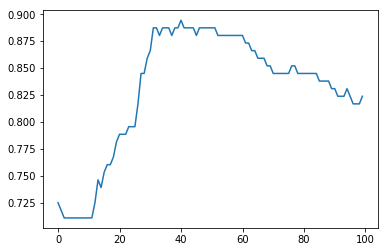

In [31]:
plt.plot(accs)
plt.show()

In [32]:
weighted_accuracy(y_train_preds_var, y_train, threshold)

0.7719298245614035

In [33]:
weighted_accuracy(y_val_preds_var, y_val, threshold)

0.8943661971830986

### Test

In [34]:
weighted_accuracy(y_test_preds_var, y_test, threshold)

0.8169014084507042

Done!